### 1. Imports

In [30]:
import warnings

import numpy as np 
import pandas as pd 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from transformers import logging
logging.set_verbosity_error()

import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import os
import importlib.metadata as mt

from sklearn.model_selection import train_test_split


In [31]:
RANDOM_STATE = 50

In [32]:
from transformers import BertTokenizer, TFBertModel

In [33]:
print("TensorFlow version:", tf.__version__)
print('keras_nlp version:', mt.version('keras_nlp'))
!python --version

TensorFlow version: 2.18.0-dev20240828
keras_nlp version: 0.0.2
Python 3.12.5


### 2.   Initialize the TPU or GPU and creat path_csv

In [34]:
# Let's create an array path_csv with paths to CSV files containing the data.
current_directory = os.getcwd()
print(current_directory)

path_csv =[]
for dirname, _, filenames in os.walk(current_directory):
      for filename in filenames:
         if filename.lower().endswith('.csv') and 'Data' in dirname :
             path_csv.append(os.path.join(dirname, filename))
path_csv

C:\Users\dmitr\OneDrive\Рабочий стол\Kaggle_projects\Contradictory, My Dear Watson


['C:\\Users\\dmitr\\OneDrive\\Рабочий стол\\Kaggle_projects\\Contradictory, My Dear Watson\\Data\\contradictory-my-dear-watson\\sample_submission.csv',
 'C:\\Users\\dmitr\\OneDrive\\Рабочий стол\\Kaggle_projects\\Contradictory, My Dear Watson\\Data\\contradictory-my-dear-watson\\test.csv',
 'C:\\Users\\dmitr\\OneDrive\\Рабочий стол\\Kaggle_projects\\Contradictory, My Dear Watson\\Data\\contradictory-my-dear-watson\\train.csv']

In [35]:
# Initialize the TPU. TPUClusterResolver automatically determines the TPU configuration.
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print(tf.config.list_physical_devices())
    
# If the TPU is not available, MirroredStrategy is used for distributed training on multiple 
# GPUs (or on CPU if GPUs are unavailable)."   
except ValueError:
    # strategy = tf.distribute.get_strategy() # for CPU and single GPU
    strategy = tf.distribute.MirroredStrategy() #  for cpu andfor multiple GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)
    print(tf.config.list_physical_devices())
    

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of replicas: 1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [36]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
BATCH_SIZE

16

## 3. Data Loading

In [40]:
path_csv

['C:\\Users\\dmitr\\OneDrive\\Рабочий стол\\Kaggle_projects\\Contradictory, My Dear Watson\\Data\\contradictory-my-dear-watson\\sample_submission.csv',
 'C:\\Users\\dmitr\\OneDrive\\Рабочий стол\\Kaggle_projects\\Contradictory, My Dear Watson\\Data\\contradictory-my-dear-watson\\test.csv',
 'C:\\Users\\dmitr\\OneDrive\\Рабочий стол\\Kaggle_projects\\Contradictory, My Dear Watson\\Data\\contradictory-my-dear-watson\\train.csv']

In [9]:
# Attention: make sure the path is correct!!!
df_train = pd.read_csv(path_csv[2])  #  data_train
df_test = pd.read_csv(path_csv[1])   #  data_test
df_example =pd.read_csv(path_csv[0])  #  predict example

Let's review and analyze the loaded data.


In [10]:
df_train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.3+ KB


In [12]:
RESULT_DICT = {
    0 : "entailment",
    1 : "neutral",
    2 : "contradiction"
}

In [13]:
df_test.head()

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


In [14]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5195 entries, 0 to 5194
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          5195 non-null   object
 1   premise     5195 non-null   object
 2   hypothesis  5195 non-null   object
 3   lang_abv    5195 non-null   object
 4   language    5195 non-null   object
dtypes: object(5)
memory usage: 203.1+ KB


In [15]:
[f'{x}' for x in  df_train['label'].value_counts().sort_values()]

['3880', '4064', '4176']

In [16]:
 df_train['language'].unique().shape[0]

15

In [17]:
def barh_col (data : pd.Series , dict : dict=None):
    if dict is None:
       dict={ y:x for y, x in enumerate(data.value_counts().sort_values().index)}
    if data.unique().shape[0] <=6:
        size=4
    else:
        size=6

    fig, ax = plt.subplots(figsize=(12, size))

    ax =  data.value_counts().sort_values().plot(kind='barh',  color=['skyblue', 'lightgreen', 'lightcoral'], edgecolor='black' )
# ax.grid(True)

    ax.set_yticklabels( [ dict.get(x,x) for x in ax.get_yticks()])
    ax.set_ylabel('Labels', fontsize=14)
    ax.tick_params(axis='y', labelrotation=45)

    ax.set_xlabel('Values', fontsize=14, labelpad=10) 

    ax.set_title('Target Labels Distribution', fontsize=16, pad=20)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    container = ax.containers[0]
    labels= [f'{x}' for x in  data.value_counts().sort_values()]
    ax.bar_label(container, labels=labels, fontsize=12, padding=5, color='black')

    plt.tight_layout()
    plt.show()

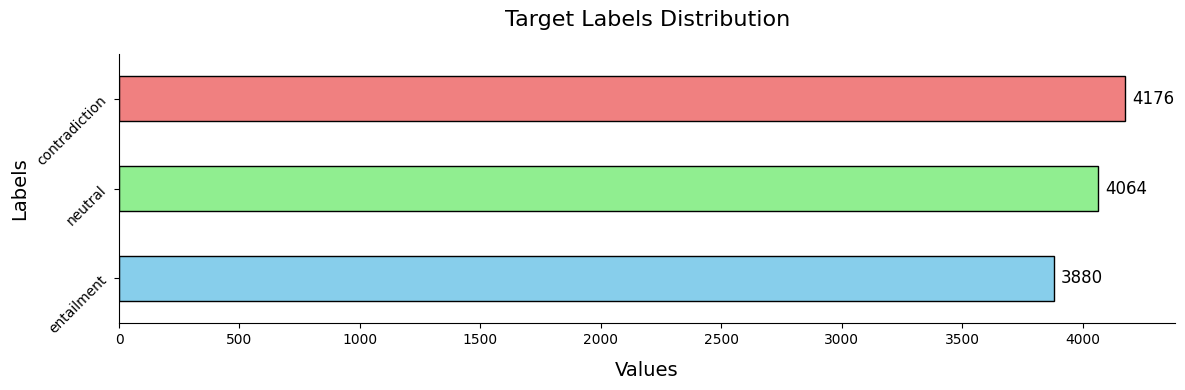

In [17]:
barh_col(df_train['label'],RESULT_DICT)

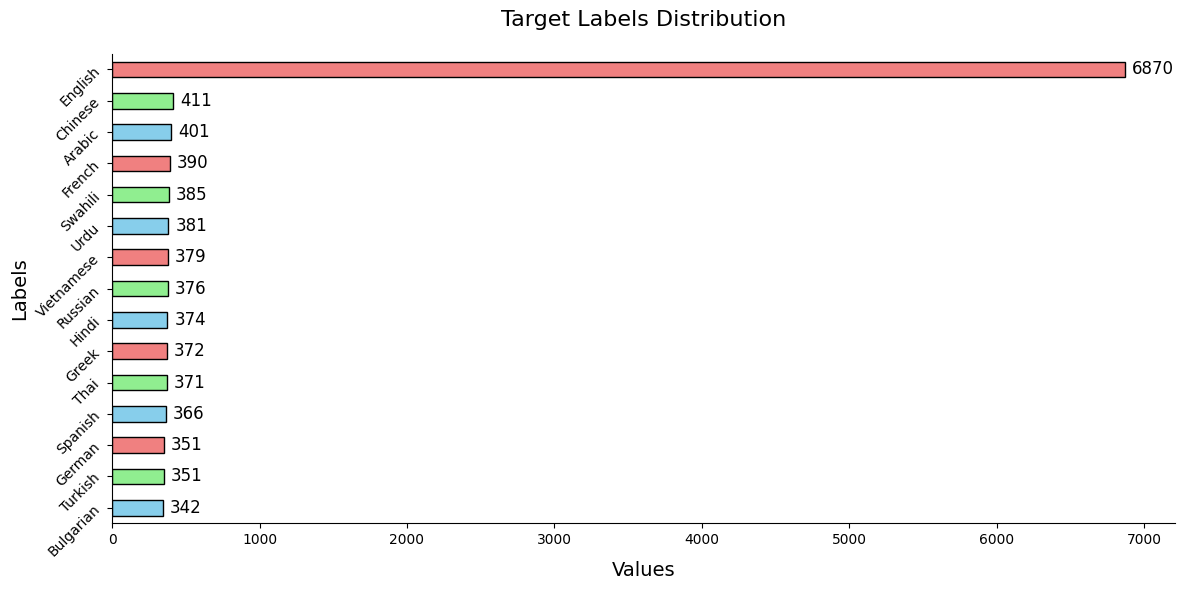

In [18]:
barh_col(df_train['language'])

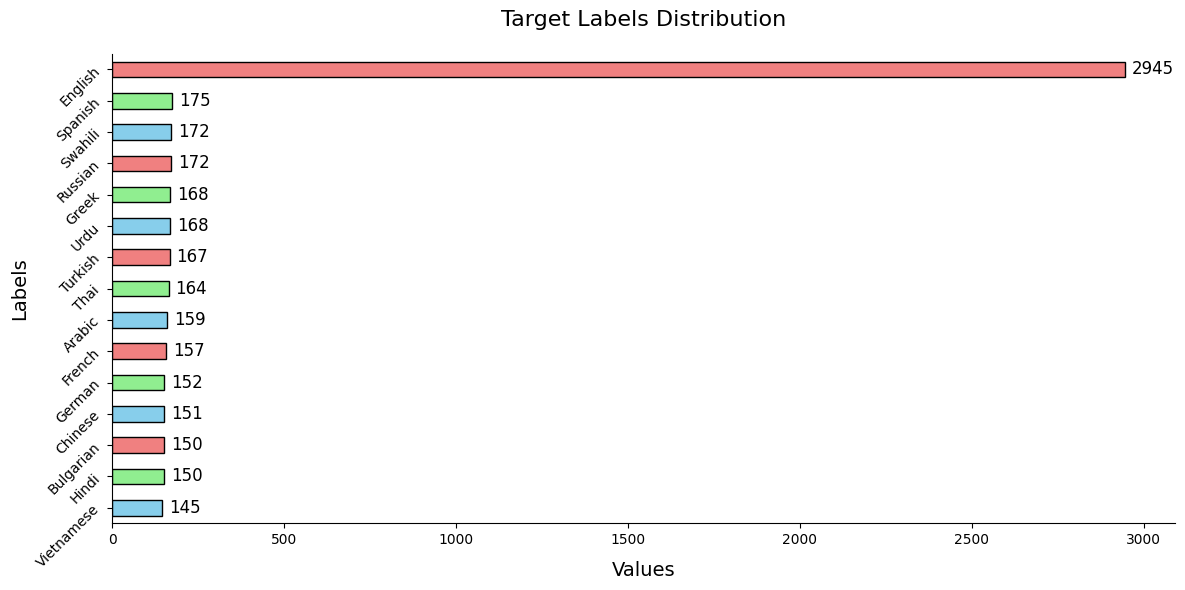

In [18]:
barh_col(df_test['language'])

In [20]:
df_test['language'].value_counts()

language
English       2945
Spanish        175
Russian        172
Swahili        172
Urdu           168
Greek          168
Turkish        167
Thai           164
Arabic         159
French         157
German         152
Chinese        151
Hindi          150
Bulgarian      150
Vietnamese     145
Name: count, dtype: int64

### Data Spliting

In [20]:
X = df_train.drop('label', axis=1)
y = df_train.label

In [21]:
X_train, X_valid, y_train,  y_valid = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2, stratify=y)

### 4. Data Encoding 

In [22]:
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name,clean_up_tokenization_spaces=True)

In [23]:
def length_max_token(data):
    row = (data['premise']+data['hypothesis']).str.split().apply(len).idxmax()
    return len(tokenizer.encode_plus(data['premise'][row], data['hypothesis'][row]).input_ids)

In [24]:
max_length = length_max_token(df_train) if length_max_token(df_train)> length_max_token(df_test) else length_max_token(df_test)
max_length

259

In [25]:
def bert_encoding(data,max_length=max_length):
    texts = zip(data.premise,data.hypothesis)
    encoding = tokenizer.batch_encode_plus(
    texts,              
    add_special_tokens=True,         # Добавить специальные токены ([CLS] и [SEP])
    max_length=max_length,           # Максимальная длина последовательности
    padding='max_length',            # Заполнить до max_length
    truncation=True,                 # Обрезать, если длина превышает max_length
    return_attention_mask=True,      # Вернуть маску внимания (attention mask)
    return_token_type_ids=True,      # Вернуть типы токенов (token type ids)
    return_tensors='tf',             # Вернуть тензоры tf
    return_overflowing_tokens=False  # Не возвращать избыточные токены    
    )    
    return encoding

In [26]:
X_train_encoding = bert_encoding(X_train)
X_valid_encoding = bert_encoding(X_valid)
df_test_encoding =  bert_encoding(df_test)

X_train_encoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [27]:
print(f' The shape of the tensor X_train_encoding.input_ids:  {X_train_encoding.input_ids.shape}')
print(f' The shape of the tensor X_valid_encoding.input_ids:  {X_valid_encoding.input_ids.shape}')
print(f' The shape of the tensor df_test_encoding.input_ids:  {df_test_encoding.input_ids.shape}')

 The shape of the tensor X_train_encoding.input_ids:  (9696, 259)
 The shape of the tensor X_valid_encoding.input_ids:  (2424, 259)
 The shape of the tensor df_test_encoding.input_ids:  (5195, 259)


In [28]:
features_tuple_train = (X_train_encoding.input_ids, X_train_encoding.attention_mask, X_train_encoding.token_type_ids)
features_tuple_valid = (X_valid_encoding.input_ids, X_valid_encoding.attention_mask, X_valid_encoding.token_type_ids)

feature_tuple_test = (df_test_encoding.input_ids, df_test_encoding.attention_mask, df_test_encoding.token_type_ids)

In [29]:
training_dataset = tf.data.Dataset.from_tensor_slices(((features_tuple_train), y_train))
valid_dataset = tf.data.Dataset.from_tensor_slices(((features_tuple_valid),y_valid))    
print( training_dataset.element_spec)
print(valid_dataset.element_spec)

((TensorSpec(shape=(259,), dtype=tf.int32, name=None), TensorSpec(shape=(259,), dtype=tf.int32, name=None), TensorSpec(shape=(259,), dtype=tf.int32, name=None)), TensorSpec(shape=(), dtype=tf.int64, name=None))
((TensorSpec(shape=(259,), dtype=tf.int32, name=None), TensorSpec(shape=(259,), dtype=tf.int32, name=None), TensorSpec(shape=(259,), dtype=tf.int32, name=None)), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [30]:
training_dataset = training_dataset.batch(BATCH_SIZE) 
training_dataset = training_dataset.cache().prefetch(tf.data.AUTOTUNE)

valid_dataset = valid_dataset.batch(BATCH_SIZE) 
valid_dataset = valid_dataset.cache().prefetch(tf.data.AUTOTUNE)

In [62]:
training_dataset.element_spec

((TensorSpec(shape=(None, 259), dtype=tf.int32, name=None),
  TensorSpec(shape=(None, 259), dtype=tf.int32, name=None),
  TensorSpec(shape=(None, 259), dtype=tf.int32, name=None)),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [31]:
print(training_dataset.cardinality())
print(valid_dataset.cardinality())

tf.Tensor(606, shape=(), dtype=int64)
tf.Tensor(152, shape=(), dtype=int64)


In [ ]:
testing_dataset = tf.data.Dataset.from_tensor_slices(feature_tuple_test)

testing_dataset = testing_dataset.batch(BATCH_SIZE) 
testing_dataset = testing_dataset.map(lambda x1, x2, x3: ((x1, x2, x3),))
testing_dataset = testing_dataset.cache().prefetch(tf.data.AUTOTUNE)

In [61]:
testing_dataset.element_spec

((TensorSpec(shape=(None, 259), dtype=tf.int32, name=None),
  TensorSpec(shape=(None, 259), dtype=tf.int32, name=None),
  TensorSpec(shape=(None, 259), dtype=tf.int32, name=None)),)

In [34]:
testing_dataset.cardinality().numpy()

325

###  5. Creating model

In [ ]:
# Определение модели и входных данных
model_name = 'bert-base-multilingual-cased'
bert_encoder = TFBertModel.from_pretrained(model_name)
bert_encoder.trainable = True
# Определение кастомного слоя
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert_model = bert_model
    
    def call(self, inputs):
        input_ids, attention_mask, token_type_ids = inputs
        return self.bert_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        ).last_hidden_state

def create_model():
   # Определение входных данных
    input_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32)
    attention_mask = tf.keras.Input(shape=(max_length,), dtype=tf.int32)
    token_type_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32)
   
   # Создание кастомного слоя
    bert_layer = BertLayer(bert_encoder)
    embeddings = bert_layer([input_ids, attention_mask, token_type_ids])
    
    
    
    attention_out = layers.MultiHeadAttention(
        num_heads=8,   # Количество голов внимания
        key_dim=768,   # Размерность ключей и значений (тот же размер, что и эмбеддингов)
        dropout=0.1    # Вероятность дропаута (опционально)
     )(embeddings, embeddings)  # Используем один и тот же тензор для query, key и value
    
    attention_out = layers.LayerNormalization(epsilon=1e-6)(attention_out + embeddings)

    
    model = layers.Dense(units=520, activation='relu')(attention_out[:,0,:])
    model= layers.Dropout(0.3)(model)
    model = layers.Dense(units=260, activation='relu')(model)
    model = layers.Dense(units=120, activation='relu')(model)
    model = layers.Dropout(0.2)(model)
    model = layers.Dense(units=60, activation='relu')(model)
    model = layers.Dense(units=30, activation='relu')(model)    
    outputs = layers.Dense(units=3, activation='softmax')(model)

  # Определение модели
    model = tf.keras.Model(inputs=(input_ids, attention_mask, token_type_ids), outputs=outputs)
    return model


In [40]:

with strategy.scope():
    model =create_model()
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [41]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 259)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_4 (InputLayer)    │ (None, 259)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_5 (InputLayer)    │ (None, 259)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_layer_1 (BertLayer)      │ (None, 259, 768)          │               0 │ input_layer_3[0][0],       │
│                               │                           │                 │ input_layer_4[0][0],       │
│                               │                           │                 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_1 (GetItem)          │ (None, 768)               │               0 │ bert_layer_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 16)                │          12,304 │ get_item_1[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 8)                 │             136 │ dense_3[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 3)                 │              27 │ dense_4[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 12,467 (48.70 KB)

 Trainable params: 12,467 (48.70 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
EPOCH = 35

try:
model.fit(training_dataset, validation_data=valid_dataset, 
          epochs = EPOCH, verbose = 2,
          steps_per_epoch=training_dataset.cardinality().numpy(),
          validation_steps=valid_dataset.cardinality().numpy()
         )
except:
model.fit(training_dataset, validation_data=valid_dataset, 
          EPOCH = 2, verbose = 2
           )

Epoch 1/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 55s 19s/step - accuracy: 0.2969 - loss: 1.2304 - val_accuracy: 0.2500 - val_loss: 1.1693
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 44s 18s/step - accuracy: 0.2995 - loss: 1.1166 - val_accuracy: 0.2708 - val_loss: 1.1062


In [83]:
training_dataset.cardinality().numpy()

606

### 6. Tasting date

In [74]:
df_example.id.equals(df_test.id)

True

In [75]:
pred =model.predict(testing_dataset)

10/10 ━━━━━━━━━━━━━━━━━━━━ 76s 8s/step


In [81]:
df_example.head(3)

,id,prediction
0,c6d58c3f69,1
1,cefcc82292,1
2,e98005252c,1


In [80]:
submission = df_example.copy()
submission.prediction = pred.argmax(axis=1)

submission.to_csv('submission.csv', index=False)